In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize']=(6,6)
#plt.rcParams['font.weight']='bold'
#plt.rcParams['axes.labelweight']='bold'
#plt.rcParams['lines.linewidth']=1.5
#plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:

ds = np.linspace(-0.7, -.3, 5)

es = np.linspace(1.5, 1.9, 5)

zhist = []
eighist = []
gammas = []
for d in ds[:-1]:
    for e in es:

        mygs = TokaMaker()
        mygs.settings.pm=False
        mygs.update_settings()
        mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh_0801_nolim.h5')
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
        mygs.setup(order=2,F0=1*3)

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)

        #Constrain CS current
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[1,0] = -1
        coil_reg_mat[2,2] = 1
        coil_reg_mat[2,1] = -1

        targets[0] = -3E6

        coil_weights[:3] = 5

        #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1

        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

        #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

        #Turn off divertor coils
        coil_bounds[-3:-1, 0] = 0
        coil_bounds[-3:-1, 1] = 0

        mygs.set_coil_bounds(coil_bounds)

        # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
        # Set F*F' profile
        alpha = 2
        gamma = 1.25
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 1.25
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 0.75E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

        print(d)
        print(e)
        r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        boundary = np.nan_to_num(boundary)

        isoflux_weights = 50*np.ones(len(boundary))

        mygs.set_isoflux(boundary, isoflux_weights)

        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 50*np.ones(2)
        mygs.set_saddles(x_points, x_weights)

        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        psi0 = mygs.get_psi(False)
        # Compute linear stability
        eig_vals, eig_vecs = mygs.eig_td(-1.E5,10,False)
        gammas.append(eig_vals[0][0])
        eig_sign = eig_vecs[0,mygs.r[:,1]>0.0][abs(eig_vecs[0,mygs.r[:,1]>0.0]).argmax()]

        psi_ic = psi0-0.01*eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_sign
        mygs.set_psi(psi_ic)
        mygs.set_saddles(None)
        mygs.set_isoflux(None)
        dt = 0.2/abs(eig_vals[0,0])
        mygs.setup_td(dt,1.E-13,1.E-11)
        sim_time = 0.0
        results = []
        z0 = [[sim_time,mygs.o_point[1]],]
        eig_vals, eig_vecs = mygs.eig_td(-1.E5,10,False)
        eig = [eig_vals[0][0]]
        for i in range(100):
            print(eig[-1])
            if eig[-1]>0:
                break
            sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
            z0.append([sim_time,mygs.o_point[1]])
            results.append(mygs.get_psi())
            eig_vals, eig_vecs = mygs.eig_td(-1.E5,10,False)
            eig.append(eig_vals[0][0])
        zhist.append(z0)
        eighist.append(eig)
        mygs.reset()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5557
    # of edges   =   16552
    # of cells   =   10996
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  3.419E-02
    hmax =  1.0

-574.7136846166541
-573.1507125729404
-564.4503215993609
-553.8935627458995
-544.3401009234076
-537.0063372572913
-524.754232973326
-519.2503828237241
-505.79010380445106
-500.0769355008524
-487.5645244102925
-481.9344375181681
-481.11957112357777
-484.9474220919219
-482.9845394961594
-485.2006070625939
-488.93055252727936
-498.44078440887097
-512.434889537617
-525.3510710607952
-553.511903896986
-595.3808257650671
-640.6055171643966
-706.9166432285128
-820.9215311659209
-971.1098130217288
-1280.2054367936362
-1914.766818155127
-5053.267630910428
-239.8473005687847
-146.06645994185237
-92.06969427665172
-63.869732344552176
-50.87444788838911
-29.188865032498143
-61.288900868734345
-79.22521678988414
-63.24727504547627
-62.24305569966964
-104.7417333053163
-27.292236940120347
-26.146726542676333
32.86978836984781

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5557
    # of edges   =   165

In [4]:
print(eighist)

[[-323.64715110647376, -326.4660583715158, -320.99999876870424, -317.3926952682086, -313.1731678664364, -309.15483626618516, -306.1233828659897, -301.4847952959244, -298.4340039682429, -296.26889425487025, -287.68418230090174, -287.9245341622591, -286.09436075341364, -286.6370366550691, -283.6249530260393, -287.8846845486405, -292.44233677364537, -301.4118167149427, -310.25672079123615, -320.1475123518903, -340.01981343346415, -374.0473932443274, -416.37913011306955, -476.6994097842544, -580.9366559538175, -788.8952194783778, -1409.210765091455, -2451.8096248581714, -11341.870772762937, 35.189649442516384], [-387.6659468439466, -391.46841265045805, -382.16405207348, -377.9825777001679, -378.48959612591716, -372.37804987397976, -366.04213821084704, -358.66042952789576, -351.81174203558476, -350.0438578451285, -342.23714893888973, -339.34305700197, -339.6726967789582, -343.47534411310335, -344.38712658159784, -344.89360334936646, -349.05053174489876, -352.15995969115465, -363.48812110017

-11341.870772762937
-3637.406082222893
-2625.4450738511514
-9756.41605327683
-8577.155377345902
-27454.301614612574
-1775.6277119590231
-19494.873993122907
-5053.267630910428
-3561.7479964837403
-10496.46663627631
-2986.9316062426515
-3347.2161907831032
-50263.297271434014
-5222.631522268828
-43827.516831522575
-9967.280644287064
-1150.2647362045827
-8977.736751960721
-2823.6925834274007


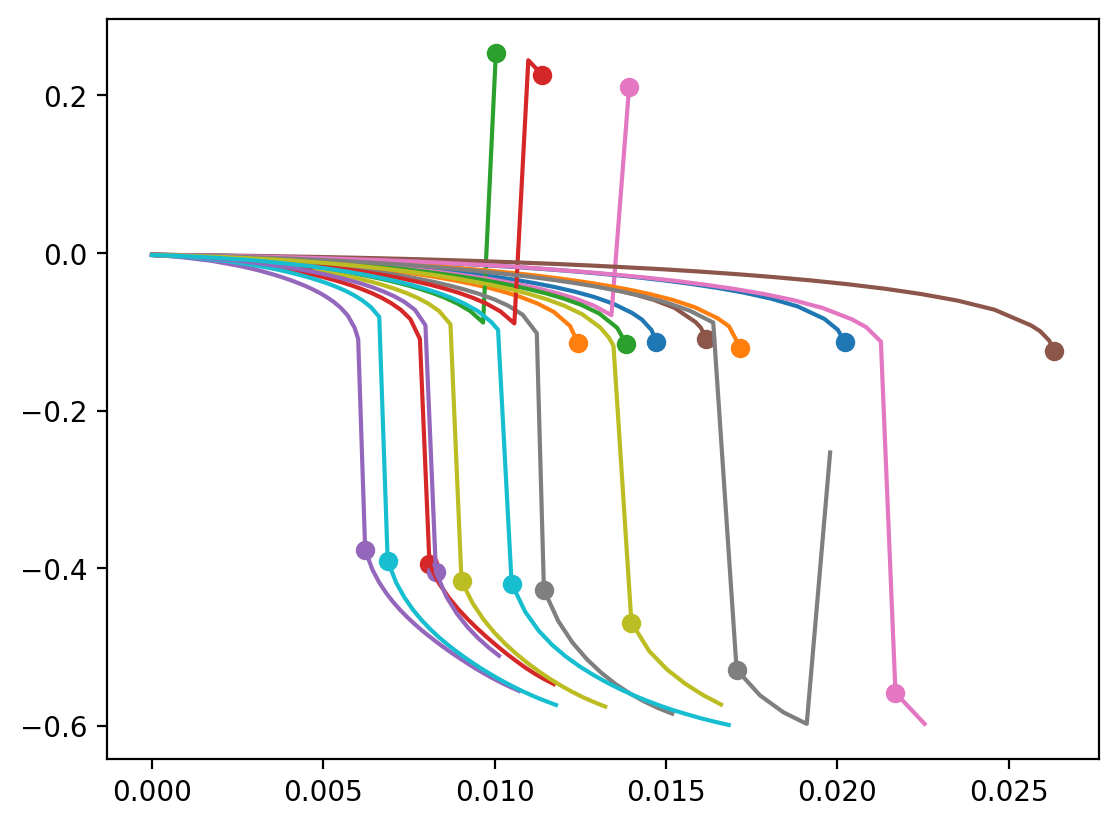

In [10]:
tmax = []
zmax = []
for i,z0 in enumerate(zhist):
    z_hist = np.asarray(z0); z_hist = z_hist[1:,:] - [z_hist[1,0], z_hist[0,1]]
    ind = np.argmin(eighist[i])
    print(np.min(eighist[i]))
    zmax.append(z_hist[ind,1])
    plt.plot(z_hist[:,0], z_hist[:,1])
    plt.scatter(z_hist[ind,0], z_hist[ind,1])

In [7]:
print(zmax)

[-0.11263831034885004, -0.1147849479059147, 0.25384450443014295, -0.39517376953320515, -0.37645082568616905, -0.10900222295724145, 0.21065613394015706, -0.4275097211070387, -0.41626635307947, -0.39063282108888286, -0.11316085031298355, -0.12007906170740239, -0.11513654136773362, 0.22596196457955114, -0.4053297278523278, -0.1244008175951624, -0.558298366933932, -0.5286992843979201, -0.46901800775690095, -0.4196843443667439]


In [24]:
print(results[0])

[ 2.99184596  2.79226263  2.60081011 ... -4.71284711 -3.81138633
 -3.37237529]


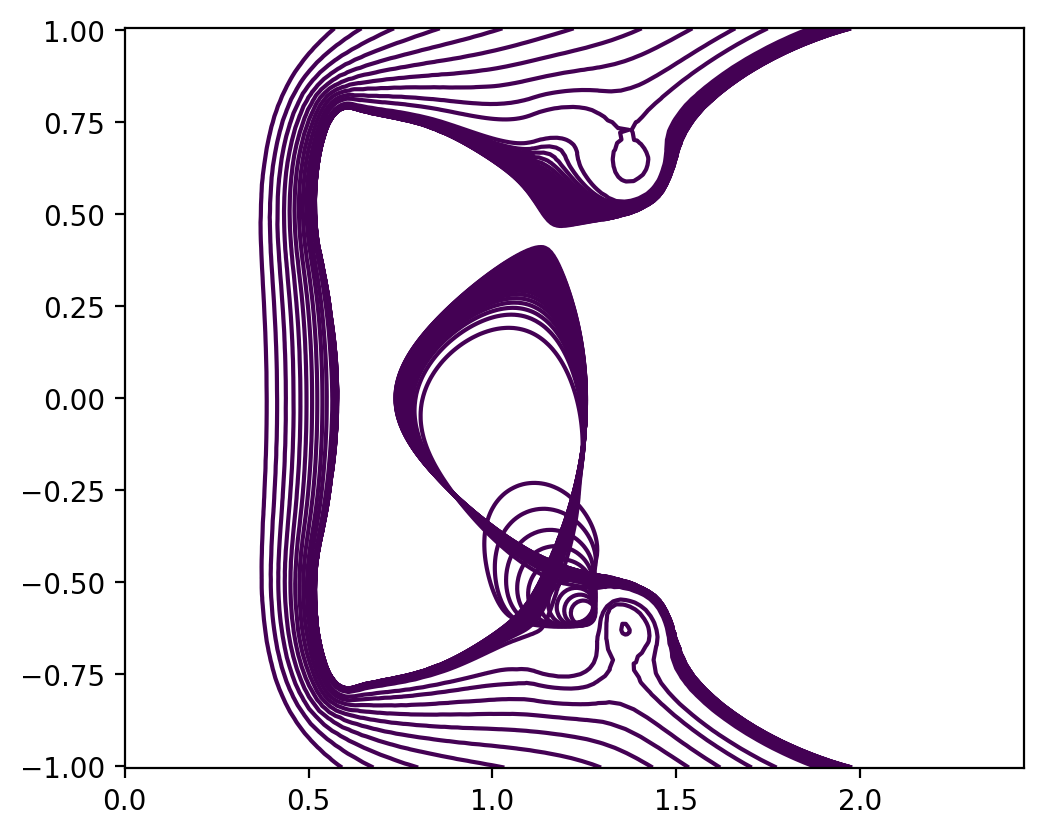

In [25]:
fig, ax = plt.subplots()
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1, vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)

In [10]:
print(zmax)
#[-0.11263831040530375, -0.1147849478559654, -0.08827660711976668, -0.5471712769970382, -0.5557220591932376, -0.10900222297098273, -0.07895390241700229, -0.5847017443046756, -0.5757312923513347, -0.5736674487151439, -0.11316085027912381, -0.12007906214506985, -0.11513654133967863, -0.08941735950628274, -0.5111625273345611, -0.12440081774578957, -0.597598023131603, -0.5976546586720561, -0.5730581191594779, -0.5990179973617772]
#1.5 - [-0.12026287368780011]
#1.6 - [-0.135891718636477]
#1.7 - [-0.1286621428730263]
#1.8 - [-0.5966685630516679]
#1.9 - [-0.5868125561507398]

[-0.5868125561507398]


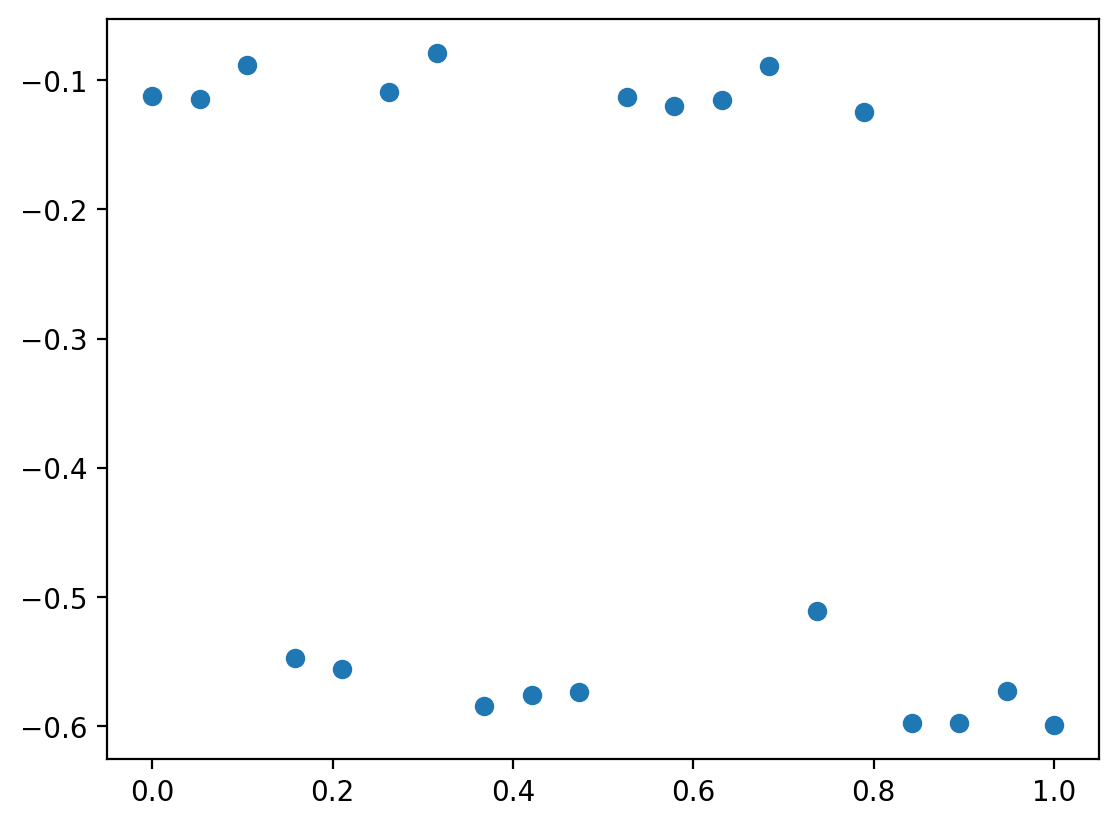

In [15]:
plt.scatter(np.linspace(0,1,len(zmax)), zmax)
